# DNACipher inference

Welcome to the inference tutorial for DNACipher, which performs double imputation, i.e. infers variant effects for both unseen sequences and unseen cell type assay combinations (based on a Pytorch model that learns the relationship between sequence, celltype, and assay, enabling any combination of these inputs to infer variant effect). This is visualisation as below:

***Know the image display won't work yet, will when made public the github repo...***
![My Image](https://github.com/BradBalderson/MRFF/blob/main/img/X1_schematic.png)

# Environment Setup

Downloaded the MRFF repo as a zip folder: https://github.com/BradBalderson/MRFF

First go to google drive and upload the zip file: https://drive.google.com/drive/my-drive

In [1]:
#### Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/MRFF-main.zip

Archive:  /content/drive/MyDrive/MRFF-main.zip
5245b20209748f85ee54af91a102b2914803f0f4
   creating: MRFF-main/
  inflating: MRFF-main/.gitignore    
 extracting: MRFF-main/.gitkeep      
  inflating: MRFF-main/README.md     
   creating: MRFF-main/data/
   creating: MRFF-main/data/test_data/
  inflating: MRFF-main/data/test_data/Index of _epimap_data_imputed.html  
   creating: MRFF-main/data/tutorial_data/
  inflating: MRFF-main/data/tutorial_data/TRAINPRECOMPFAST_MEAN_ENCODE_V4_AVG-GENFILT_BATCH1024_LR1e-5_EPOCH300_F1280_SMALL2_NCF6_NAF12_RELU-OUT_PEAK_LESSDROP_model_weights.pth  
  inflating: MRFF-main/data/tutorial_data/encode_meta_encode_imputable_fixed.train-test.txt  
  inflating: MRFF-main/data/tutorial_data/gtex_variants_SMALL.vcf  
   creating: MRFF-main/data/variant/
 extracting: MRFF-main/data/variant/.gitkeep  
   creating: MRFF-main/docs/
  inflating: MRFF-main/docs/index.md  
  inflating: MRFF-main/docs/log.md   
  inflating: MRFF-main/docs/requirements_wiener.txt  
   

In [3]:
!ls

drive  MRFF-main  sample_data


In [4]:
work_dir = 'MRFF-main/'
import os, sys
os.chdir(work_dir)

In [5]:
##### Installing dependencies
!pip install pyfaidx
!pip install kipoiseq
!pip install pytorch_lightning

try:
    import nucleotide_transformer
except:
    !pip install numpy==1.23.5
    !pip install git+https://github.com/instadeepai/nucleotide-transformer@main |tail -n 1
    import nucleotide_transformer

if "COLAB_TPU_ADDR" in os.environ:
    from jax.tools import colab_tpu

    colab_tpu.setup_tpu()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/103.0 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.5/41.5 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 9.8 MB/s eta 0:00:00
  Attempting uninstall: attrs
    Found existing installation: attrs 23.1.0
    Uninstalling attrs-23.1.0:
      Successfu

In [6]:
##### Importing dependencies
import sys
import torch

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sb

sys.path.append('scripts/seqcipher/')
import helpers.dna_cipher_infer as dnaci

import importlib as imp
import jax

import pyfaidx

In [7]:
#### Paths
temp_path = 'data/tutorial_data/tmp/'
weights_path = 'data/tutorial_data/TRAINPRECOMPFAST_MEAN_ENCODE_V4_AVG-GENFILT_BATCH1024_LR1e-5_EPOCH300_F1280_SMALL2_NCF6_NAF12_RELU-OUT_PEAK_LESSDROP_model_weights.pth'
fasta_file_path = 'data/tutorial_data/tmp/genome.fa'
gtex_vars_path = 'data/tutorial_data/gtex_variants_SMALL.vcf'
sample_file_path = 'data/tutorial_data/encode_meta_encode_imputable_fixed.train-test.txt'

## Checking we are detecting GPU for both JAX and Pytorch

In [8]:
device = 'cuda:0'

In [9]:
print("JAX backend: ", jax.default_backend())
print("Cuda available: ", torch.cuda.is_available())
print("Num GPUs Available: ", torch.cuda.device_count())

JAX backend:  gpu
Cuda available:  True
Num GPUs Available:  1


## Downloading data

Download and index the reference genome fasta file

Credit to Genome Reference Consortium: https://www.ncbi.nlm.nih.gov/grc

Schneider et al 2017 http://dx.doi.org/10.1101/gr.213611.116: Evaluation of GRCh38 and de novo haploid genome assemblies demonstrates the enduring quality of the reference assembly

In [10]:
!mkdir -p {temp_path}
!wget -O - http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz | gunzip -c > {fasta_file_path}
pyfaidx.Faidx(fasta_file_path)
!ls {temp_path}

--2023-08-30 03:35:30--  http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz
Resolving hgdownload.cse.ucsc.edu (hgdownload.cse.ucsc.edu)... 128.114.119.163
Connecting to hgdownload.cse.ucsc.edu (hgdownload.cse.ucsc.edu)|128.114.119.163|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 983659424 (938M) [application/x-gzip]
Saving to: ‘STDOUT’

-                   100%[===================>] 938.09M  35.2MB/s    in 26s     

2023-08-30 03:35:56 (36.5 MB/s) - written to stdout [983659424/983659424]

genome.fa  genome.fa.fai


## Loading example GTEX eQTL variant data

In [11]:
var_df = pd.read_csv(gtex_vars_path, sep='\t', header=0)
var_df.shape, var_df.head(4)

((49, 8),
      CHR       POS REF ALT             GENE_ID  TSS_DIST    SLOPE  \
 0  chr13  50909867   G   C  ENSG00000136104.19       189 -1.88838   
 1  chr13  50909048   T   C  ENSG00000136104.19      -630 -1.93409   
 2  chr14  24036431   C   T   ENSG00000225766.9       -22 -1.59680   
 3  chr13  50909867   G   C  ENSG00000136104.19       189 -1.96015   
 
                      TISSUE  
 0      Adipose_Subcutaneous  
 1  Adipose_Visceral_Omentum  
 2             Adrenal_Gland  
 3              Artery_Aorta  )

## Loading the DNACipher model

NOTE that this may take a little time, since need to download the Nucleotide Transform weights and model.

In [12]:
dnacipher = dnaci.DNACipher(weights_path, sample_file_path, fasta_file_path, device=device)

/root/.cache/nucleotide_transformer/500M_human_ref/hyperparams.json: 100%|██████████| 815/815 [00:00<00:00, 2.78kB/s]
/root/.cache/nucleotide_transformer/500M_human_ref/ckpt.joblib: 100%|██████████| 1.94G/1.94G [00:22<00:00, 85.9MB/s]


## Performing inference on variants.

DNACipher offers a few different interfaces to perform inference of variant effects.

The most specific function takes as input CHR, POS, REF, ALT and also the CELLTYPE, ASSAY and provides effect prediction.

We provide a dictionary below which maps the GTEX tissues to the equivalent ENCODE biosample names:

In [13]:
# GTEX to ENCODE.
tissue_map = {
    'Adipose_Subcutaneous': ['subcutaneous abdominal adipose tissue'],
    'Adipose_Visceral_Omentum': ['omental fat pad'],
    'Adrenal_Gland': ['adrenal gland'],
    'Artery_Aorta': ['aorta', 'ascending aorta', 'thoracic aorta'],
    'Artery_Coronary': ['coronary artery'],
    'Artery_Tibial': ['tibial artery'],
    'Brain_Amygdala': ['brain'],
    'Brain_Anterior_cingulate_cortex_BA24': ['cingulate gyrus'],
    'Brain_Caudate_basal_ganglia': ['caudate nucleus'],
    'Brain_Cerebellar_Hemisphere': ['cerebellum'],
    'Brain_Cerebellum': ['cerebellum'],
    'Brain_Cortex': ['brain'],
    'Brain_Frontal_Cortex_BA9': ['dorsolateral prefrontal cortex'],
    'Brain_Hippocampus': ['layer of hippocampus'],
    'Brain_Hypothalamus': ['brain'],
    'Brain_Nucleus_accumbens_basal_ganglia': ['brain'],
    'Brain_Putamen_basal_ganglia': ['brain'],
    'Brain_Spinal_cord_cervical_c-1': ['spinal cord'],
    'Brain_Substantia_nigra': ['substantia nigra'],
    'Breast_Mammary_Tissue': ['breast epithelium', 'luminal epithelial cell of mammary gland'],
    'Cells_Cultured_fibroblasts': ['foreskin fibroblast', 'fibroblast of dermis', 'fibroblast of lung', 'fibroblast of the aortic adventitia'],
    'Colon_Sigmoid': ['sigmoid colon'],
    'Colon_Transverse': ['transverse colon'],
    'Esophagus_Gastroesophageal_Junction': ['gastroesophageal sphincter'],
    'Esophagus_Mucosa': ['esophagus squamous epithelium'],
    'Esophagus_Muscularis': ['esophagus muscularis mucosa'],
    'Heart_Atrial_Appendage': ['right atrium auricular region'],
    'Heart_Left_Ventricle': ['heart left ventricle'],
    'Kidney_Cortex': ['kidney', 'kidney epithelial cell'],
    'Liver': ['liver', 'right lobe of liver'],
    'Lung': ['lung', 'left lung', 'right lung'],
    'Muscle_Skeletal': ['skeletal muscle tissue', 'muscle of leg', 'muscle of trunk'],
    'Nerve_Tibial': ['tibial nerve'],
    'Ovary': ['ovary'],
    'Pancreas': ['pancreas', 'body of pancreas'],
    'Prostate': ['prostate gland'],
    'Skin_Not_Sun_Exposed_Suprapubic': ['suprapubic skin'],
    'Skin_Sun_Exposed_Lower_leg': ['lower leg skin'],
    'Small_Intestine_Terminal_Ileum': ['small intestine'],
    'Spleen': ['spleen'],
    'Stomach': ['stomach', 'mucosa of stomach'],
    'Testis': ['testis'],
    'Thyroid': ['thyroid gland'],
    'Uterus': ['uterus'],
    'Vagina': ['vagina']
}

## Inferring variant effect in a particular celltype, assay combination

***We can then use this map to look up our predicted variant effect sizes.***

In [14]:
var_df.head(2)

,CHR,POS,REF,ALT,GENE_ID,TSS_DIST,SLOPE,TISSUE
0,chr13,50909867,G,C,ENSG00000136104.19,189,-1.88838,Adipose_Subcutaneous
1,chr13,50909048,T,C,ENSG00000136104.19,-630,-1.93409,Adipose_Visceral_Omentum


In [15]:
chr_, pos, ref, alt = var_df.values[0, 0:4]
chr_, pos, ref, alt

('chr13', 50909867, 'G', 'C')

We can see that the gene associated with this eQTL is on the positive strand:
https://asia.ensembl.org/Homo_sapiens/Gene/Summary?g=ENSG00000136104;r=13:50909747-51024120

So we should focus on positive-strand RNA-seq signal for the equivalent cell type:

In [16]:
celltype = tissue_map[var_df.values[0, 7]][0]
celltype

'subcutaneous abdominal adipose tissue'

In [17]:
np.array(dnacipher.assays)

array(['ATAC-seq', 'ATF2_ChIP-seq', 'ATF3_ChIP-seq', 'ATF7_ChIP-seq',
       'BHLHE40_ChIP-seq', 'BRCA1_ChIP-seq', 'CEBPB_ChIP-seq',
       'CHD1_ChIP-seq', 'CHD2_ChIP-seq', 'CREB1_ChIP-seq',
       'CTCF_ChIP-seq', 'DNase-seq', 'E2F1_ChIP-seq', 'E2F4_ChIP-seq',
       'EGR1_ChIP-seq', 'ELF1_ChIP-seq', 'ELK1_ChIP-seq',
       'EP300_ChIP-seq', 'ESRRA_ChIP-seq', 'EZH2_ChIP-seq',
       'EZH2phosphoT487_ChIP-seq', 'FOSL2_ChIP-seq', 'FOXA1_ChIP-seq',
       'FOXJ3_ChIP-seq', 'FOXK2_ChIP-seq', 'FOXM1_ChIP-seq',
       'GABPA_ChIP-seq', 'GATA2_ChIP-seq', 'GTF2F1_ChIP-seq',
       'H2AFZ_ChIP-seq', 'H3F3A_ChIP-seq', 'H3K27ac_ChIP-seq',
       'H3K27me3_ChIP-seq', 'H3K36me3_ChIP-seq', 'H3K4me1_ChIP-seq',
       'H3K4me2_ChIP-seq', 'H3K4me3_ChIP-seq', 'H3K79me2_ChIP-seq',
       'H3K9ac_ChIP-seq', 'H3K9me2_ChIP-seq', 'H3K9me3_ChIP-seq',
       'H4K20me1_ChIP-seq', 'HCFC1_ChIP-seq', 'HDAC2_ChIP-seq',
       'HDAC6_ChIP-seq', 'JUNB_ChIP-seq', 'JUND_ChIP-seq', 'JUN_ChIP-seq',
       'KDM1A_ChIP-s

In [ ]:
?dnacipher.infer_specific_effect

In [18]:
pred_effect = dnacipher.infer_specific_effect(chr_, pos, ref, alt, celltype, 'plus strand polyA plus RNA-seq',
                                              # The positions are 1-based indexing, so have to indicate this
                                              index_base=1
                                             )

In [19]:
pred_effect2 = dnacipher.infer_specific_effect(chr_, pos, ref, alt, celltype, 'plus strand total RNA-seq',
                                              # The positions are 1-based indexing, so have to indicate this
                                              index_base=1
                                             )

In [20]:
pred_effect3 = dnacipher.infer_specific_effect(chr_, pos, ref, alt, celltype, 'signal of polyA plus RNA-seq',
                                              # The positions are 1-based indexing, so have to indicate this
                                              index_base=1
                                             )

In [21]:
### NO predicted effect for this variant on the celltype-specific RNA-seq
pred_effect, pred_effect2, pred_effect3

(0.0, 0.0, 0.0)

## Inferring variant effect across celltype, assay combinations

In [ ]:
?dnacipher.infer_effects

In [22]:
pred_effects = dnacipher.infer_effects(chr_, pos, ref, alt,
                                              # The positions are 1-based indexing, so have to indicate this
                                              index_base=1
                                             )

In [23]:
pred_effects

,ATAC-seq,ATF2_ChIP-seq,ATF3_ChIP-seq,ATF7_ChIP-seq,BHLHE40_ChIP-seq,BRCA1_ChIP-seq,CEBPB_ChIP-seq,CHD1_ChIP-seq,CHD2_ChIP-seq,CREB1_ChIP-seq,...,ZNF24_ChIP-seq,ZNF274_ChIP-seq,ZZZ3_ChIP-seq,minus strand polyA minus RNA-seq,minus strand polyA plus RNA-seq,minus strand total RNA-seq,plus strand polyA minus RNA-seq,plus strand polyA plus RNA-seq,plus strand total RNA-seq,signal of polyA plus RNA-seq
A549,-0.000281,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.008596,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A673,0.000360,0.0,0.0,0.0,0.0,0.0,0.005077,0.0,0.0,0.009977,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ACC112,0.001011,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.009888,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AG04450,0.000079,0.0,0.0,0.0,0.0,0.0,0.004267,0.0,0.0,0.009473,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B cell,-0.000412,0.0,0.0,0.0,0.0,0.0,0.004260,0.0,0.0,0.009131,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
upper lobe of left lung,-0.000121,0.0,0.0,0.0,0.0,0.0,0.004411,0.0,0.0,0.009236,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
upper lobe of right lung,0.000029,0.0,0.0,0.0,0.0,0.0,0.004868,0.0,0.0,0.009321,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
urinary bladder,0.001081,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
uterus,0.000381,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


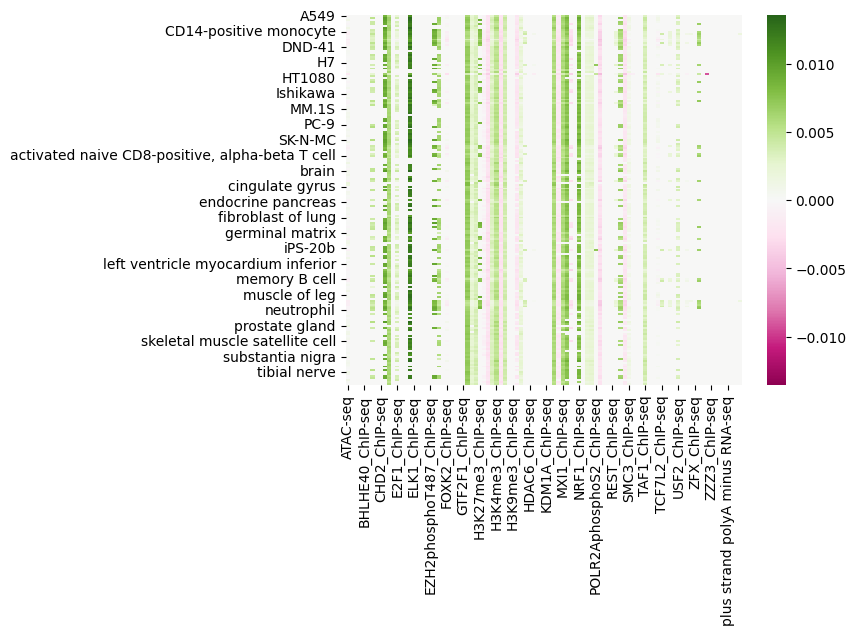

In [24]:
min_, max_ = pred_effects.values.min(), pred_effects.values.max()
range_ = max([abs(min_), abs(max_)])

sb.heatmap(pred_effects, cmap='PiYG', vmin=-range_, vmax=range_)
plt.show()

## Inferring effects across a set of variants for all celltype, assays

In [ ]:
?dnacipher.infer_multivariant_effects

In [25]:
var_df.head(3)

,CHR,POS,REF,ALT,GENE_ID,TSS_DIST,SLOPE,TISSUE
0,chr13,50909867,G,C,ENSG00000136104.19,189,-1.88838,Adipose_Subcutaneous
1,chr13,50909048,T,C,ENSG00000136104.19,-630,-1.93409,Adipose_Visceral_Omentum
2,chr14,24036431,C,T,ENSG00000225766.9,-22,-1.59680,Adrenal_Gland


In [26]:
var_pred_effects = dnacipher.infer_multivariant_effects(var_df.head(3),
                                              # The positions are 1-based indexing, so have to indicate this
                                              index_base=1
                                             )

PROCESSED 0/3 variants.
PROCESSED 3/3 variants.


In [27]:
var_pred_effects.shape, var_pred_effects.iloc[:, 0:10]

((3, 18336),
                     A549---ATAC-seq  A549---ATF2_ChIP-seq  \
 chr13_50909867_G_C        -0.000281                   0.0   
 chr13_50909048_T_C        -0.005339                   0.0   
 chr14_24036431_C_T         0.019702                   0.0   
 
                     A549---ATF3_ChIP-seq  A549---ATF7_ChIP-seq  \
 chr13_50909867_G_C                   0.0                   0.0   
 chr13_50909048_T_C                   0.0                   0.0   
 chr14_24036431_C_T                   0.0                   0.0   
 
                     A549---BHLHE40_ChIP-seq  A549---BRCA1_ChIP-seq  \
 chr13_50909867_G_C                      0.0                    0.0   
 chr13_50909048_T_C                      0.0                    0.0   
 chr14_24036431_C_T                      0.0                    0.0   
 
                     A549---CEBPB_ChIP-seq  A549---CHD1_ChIP-seq  \
 chr13_50909867_G_C                    0.0                   0.0   
 chr13_50909048_T_C                    0.0   

***We can use reshaping to visualise a specific variants effects:***

In [28]:
var0_pred_effects = var_pred_effects.values[0,:].reshape(len(dnacipher.celltypes), len(dnacipher.assays))
var0_pred_effects = pd.DataFrame(var0_pred_effects, index=dnacipher.celltypes, columns=dnacipher.assays)

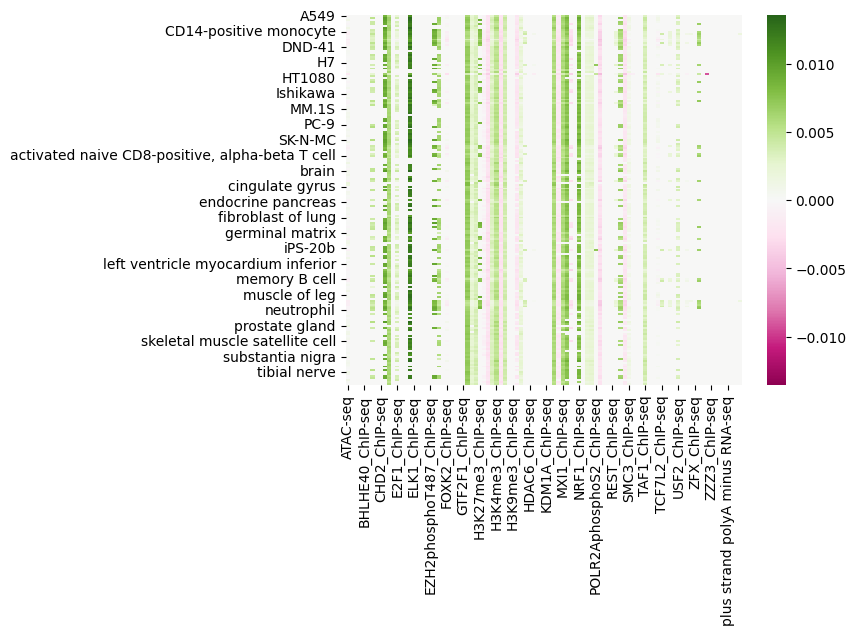

In [29]:
min_, max_ = var0_pred_effects.values.min(), var0_pred_effects.values.max()
range_ = max([abs(min_), abs(max_)])

sb.heatmap(var0_pred_effects, cmap='PiYG', vmin=-range_, vmax=range_)
plt.show()

***DONE*** More features to come...